In [1]:
import CoolProp.CoolProp as CP
import os
import fortranformat as ff
import numpy as np

In [ ]:
class SuperHeatTable(object):
    def __init__(self,Tsh_max, Tsh_min, Psh_min, Psh_max, nT, nP, fluid):
        self.nP = nP
        self.nT = nT
        self.T_vec = np.linspace(Tsh_min, Tsh_max, nT)
        self.P_vec = np.geomspace(Psh_min, Psh_max, nP)
        self.fluid = fluid
        
    def GetSuperHeatProperties(self,T,P,prop):
        if prop =='d(P)d(v)|T':
            v= 1/CP.PropsSI("D", 'P',P, "T", T, self.fluid)
            return CP.PropsSI("d(P)/d(D)|T", 'P',P, "T", T, self.fluid)*(-1/(v**2))
        elif prop =='v':
             return 1/CP.PropsSI("D", 'P',P, "T", T, self.fluid)
        else:
            return CP.PropsSI(prop,"P",P,"T",T,self.fluid )
        
    def GetPropMatrix(self,prop):
        matrix = []
        for p in self.P_vec:
            matrix.append(self.GetSuperHeatProperties(self.T_vec, p, prop))
        return  np.array(matrix)
        
    def GetPropArray(self,prop):
        matrix = []
        for p in self.P_vec:
            matrix.append(self.GetSuperHeatProperties(self.T_vec, p, prop))
        return  [item for sublist in matrix for item in sublist]
    
    def GetSatProperties(self, P, prop):
        if prop =='d(P)d(v)|T':
            v= 1/CP.PropsSI("D", 'P',P, "Q", 1, self.fluid)
            return CP.PropsSI("d(P)/d(D)|T", 'P',P, "Q", 1, self.fluid)*(-1/(v**2))
        elif prop =='v':
             return 1/CP.PropsSI("D", 'P',P, "Q", 1,  self.fluid)
        else:
            return CP.PropsSI(prop,"P",P, "Q",1, self.fluid)

    def GetSubTable(self, nr, prop):
        lines=[]
        w = ff.FortranRecordWriter('(3ES17.7E3)')
        lines.append("$TABLE_"+str(nr))
        lines.append("{:10d}".format(self.nT)+"{:10d}".format(self.nP))
        lines.append(w.write(self.T_vec))
        lines.append(w.write(self.P_vec))
        lines.append(w.write(self.GetPropArray(prop)))
        lines.append(w.write(self.GetSatProperties(self.P_vec, "T")))
        lines.append(w.write(self.GetSatProperties(self.P_vec, prop)))
        return lines
    
    def GetHeader(self, RGP_table):
        l = []
        l.append("$$$$DATA")
        l.extend(RGP_table._GetSharedHeader())
        l.append("$$SUPER_TABLE")
        l.append("{:10d}".format(9))
        return l
    
    def GetTable(self, RGP_table):
        lines = self.GetHeader(RGP_table)
        lines.extend(self.GetSubTable(1, 'H'))
        lines.extend(self.GetSubTable(2, 'A'))
        lines.extend(self.GetSubTable(3, 'v'))
        lines.extend(self.GetSubTable(4, 'CVMASS'))
        lines.extend(self.GetSubTable(5, 'CPMASS'))
        lines.extend(self.GetSubTable(6, 'd(P)d(v)|T'))
        lines.extend(self.GetSubTable(7, 'S'))
        lines.extend(self.GetSubTable(8, 'V'))
        lines.extend(self.GetSubTable(9, 'L'))
        return lines
        

In [30]:
class SaturationTable(object):
    def __init__(self,Tsat_max, Tsat_min, npoints,fluid):
        self.npoints= npoints
        self.T_vec = np.linspace(Tsat_min, Tsat_max, npoints)
        self.fluid = fluid
        self.CalcProp()
    
    def CalcProp(self):
        self.Psat = CP.PropsSI("P",          'T',self.T_vec, "Q",1,self.fluid) 
        self.Hl   = CP.PropsSI("H",          'T',self.T_vec, "Q",0, self.fluid)
        self.cpl  = CP.PropsSI("CPMASS",     'T',self.T_vec, "Q",0, self.fluid)
        self.dDdPl= CP.PropsSI("d(D)/d(P)|T",'T',self.T_vec, "Q",0, self.fluid)
        self.Sl   = CP.PropsSI("S",          'T',self.T_vec, "Q",0, self.fluid)
        self.Cvl  = CP.PropsSI("CVMASS",     'T',self.T_vec, "Q",0, self.fluid)
        self.Al   = CP.PropsSI("A",          'T',self.T_vec, "Q",0, self.fluid)
        self.Vl   = CP.PropsSI("V",          'T',self.T_vec, "Q",0, self.fluid)
        self.Ll   = CP.PropsSI("L",          'T',self.T_vec, "Q",0, self.fluid)
        self.Hg   = CP.PropsSI("H",          'T',self.T_vec, "Q",1, self.fluid)
        self.cpg  = CP.PropsSI("CPMASS",     'T',self.T_vec, "Q",1, self.fluid)
        self.dDdPg= CP.PropsSI("d(D)/d(P)|T",'T',self.T_vec, "Q",1, self.fluid)
        self.Sg   = CP.PropsSI("S",          'T',self.T_vec, "Q",1, self.fluid)
        self.Cvg  = CP.PropsSI("CVMASS",     'T',self.T_vec, "Q",1, self.fluid)
        self.Ag   = CP.PropsSI("A",          'T',self.T_vec, "Q",1, self.fluid)
        self.Vg   = CP.PropsSI("V",          'T',self.T_vec, "Q",1, self.fluid)
        self.Lg   = CP.PropsSI("L",          'T',self.T_vec, "Q",1, self.fluid)
        
    def GetHeader(self):
        lines=[]
        lines.append("$$SAT_TABLE")
        lines.append("{:10d}".format(self.npoints)+"{:10d}".format(4)+"{:10d}".format(9))
        return lines
        
    def GetValues(self):
        w = ff.FortranRecordWriter('(3ES17.7E3)')
        lines = []
        lines.append(w.write(self.Psat))
        lines.append(w.write(self.T_vec))
        lines.append(w.write([0]*len(self.T_vec)))
        lines.append(w.write([0]*len(self.T_vec)))
        lines.append(w.write(self.Hl))
        lines.append(w.write(self.cpl))
        lines.append(w.write(self.dDdPl))
        lines.append(w.write(self.Sl))
        lines.append(w.write(self.Cvl))
        lines.append(w.write(self.Al))
        lines.append(w.write(self.Vl))
        lines.append(w.write(self.Ll))
        lines.append(w.write(self.Hg))
        lines.append(w.write(self.cpg))
        lines.append(w.write(self.dDdPg))
        lines.append(w.write(self.Sg))
        lines.append(w.write(self.Cvg))
        lines.append(w.write(self.Ag))
        lines.append(w.write(self.Vg))
        lines.append(w.write(self.Lg))
        return lines
            
    def GetTable(self):
        lines = self.GetHeader()
        lines.extend(self.GetValues())
        return lines


In [31]:
class RGPTable(object):
    def __init__(self, Tsh_max, Tsh_min, Psh_min, Psh_max, Tsat_max, Tsat_min,nT, nP,nSat, fluid):
        self.fluid=fluid
        self.Tsh_max=Tsh_max
        self.Tsh_min=Tsh_min
        self.Psh_max=Psh_max
        self.Psh_min=Psh_min
        self.Tsat_max=Tsat_max
        self.Tsat_min=Tsat_min
        self.P_crit=CP.PropsSI("PCRIT",self.fluid)
        self.P_triple=CP.PropsSI("PTRIPLE",self.fluid)
        self.T_crit=CP.PropsSI("TCRIT",self.fluid)
        self.T_triple=CP.PropsSI("TTRIPLE",self.fluid)

        self.nT=nT
        self.nP=nP
        
        
        self.SHTable = SuperHeatTable(Tsh_max, Tsh_min, Psh_min, Psh_max, nT, nP, fluid)
        self.SatTable = SaturationTable(Tsat_max,Tsat_min, nSat,fluid)
    
    def GetTable(self):
        l = self.GetHeader()
        l.extend(self.SHTable.GetTable(self))
        l.extend(self.SatTable.GetTable())
        return l
        
        
    def GetHeader(self):
        l=[]
        l.append("$$$$HEADER")
        l.extend(self._GetSharedHeader())
        return l
    
    def _GetSharedHeader(self):
        l=[]
        l.append("$$$"+self.fluid)
        l.append("{:10d}".format(1))
        l.append("$$PARAM")
        l.append("{:10d}".format(26)) #integer (number of parameters)
        l.append("DESCRIPTION") 
        l.append(self.fluid+" from CoolProp") #character*50 (description of the material)    
        l.append("NAME") 
        l.append(self.fluid) #(material name, same as $$$<component>
        l.append("INDEX")
        l.append(self.fluid)
        l.append("DATABASE") 
        l.append("CoolProp")
        l.append("MODEL")
        l.append("{:10d}".format(3))
        l.append("UNITS") 
        l.append("{:10d}".format(1))
        l.append("PMIN_SUPERHEAT")
        l.append("{:23.16e}".format(self.Psh_min))
        l.append("PMAX_SUPERHEAT")
        l.append("{:23.16e}".format(self.Psh_max))
        l.append("TMIN_SUPERHEAT")
        l.append("{:23.16e}".format(self.Tsh_min))
        l.append("TMAX_SUPERHEAT")
        l.append("{:23.16e}".format(self.Tsh_max))
        l.append("TMIN_SATURATION")
        l.append("{:23.16e}".format(self.Tsat_min))
        l.append("TMAX_SATURATION")
        l.append("{:23.16e}".format(self.Tsat_max))
        l.append("SUPERCOOLING")                  
        l.append("{:23.16e}".format(0))
        l.append("P_CRITICAL")
        l.append("{:23.16e}".format(self.P_crit))
        l.append("P_TRIPLE")
        l.append("{:23.16e}".format(self.P_triple))
        l.append("T_CRITICAL")
        l.append("{:23.16e}".format(self.T_crit))
        l.append("T_TRIPLE")
        l.append("{:23.16e}".format(self.T_triple))
        for i in range(1,10):
            l.append("TABLE_"+str(i))
            l.append("{:10d}".format(self.nT)+"{:10d}".format(self.nP))
        l.append("SAT_TABLE")
        l.append("{:10d}".format(5)+"{:10d}".format(4)+"{:10d}".format(9))
        return l
    
    
    def WriteTable(self, filename):
        table=self.GetTable()
        with open(filename, 'w') as f:
            for line in table:
                f.write(line + os.linesep)
        
    
    
table = RGPTable(400, 240, 55000, 400000,350,240,  5, 5,5, "R134a")
table.WriteTable(table.fluid+".rgp")



In [ ]:
table = RGPTable(300, 600, 1e4, 35e5, \
                 CP.PropsSI("T","P",35e5, 'Q',1, "Toluene"), \
                 CP.PropsSI("T","P",1e4, 'Q',1, "Toluene"), \
                 1000, 1000,1000, "Toluene")
table.WriteTable(table.fluid+".rgp")

In [12]:
CP.PropsSI("Tcrit", "Toluene")

591.75

In [18]:
CP.PropsSI("T","P",35e5, 'Q',1, "Toluene")


318.40250048094964

In [28]:
np.geomspace(1e4,35e6, 100)

array([1.00000000e+04, 1.08592209e+04, 1.17922678e+04, 1.28054841e+04,
       1.39057580e+04, 1.51005698e+04, 1.63980423e+04, 1.78069964e+04,
       1.93370107e+04, 2.09984870e+04, 2.28027209e+04, 2.47619783e+04,
       2.68895792e+04, 2.91999880e+04, 3.17089119e+04, 3.44334079e+04,
       3.73919982e+04, 4.06047968e+04, 4.40936457e+04, 4.78822638e+04,
       5.19964079e+04, 5.64640479e+04, 6.13155568e+04, 6.65839175e+04,
       7.23049468e+04, 7.85175388e+04, 8.52639297e+04, 9.25899846e+04,
       1.00545510e+05, 1.09184590e+05, 1.18565958e+05, 1.28753392e+05,
       1.39816153e+05, 1.51829449e+05, 1.64874952e+05, 1.79041352e+05,
       1.94424959e+05, 2.11130358e+05, 2.29271119e+05, 2.48970572e+05,
       2.70362644e+05, 2.93592767e+05, 3.18818870e+05, 3.46212454e+05,
       3.75959751e+05, 4.08262998e+05, 4.43341807e+05, 4.81434661e+05,
       5.22800533e+05, 5.67720646e+05, 6.16500390e+05, 6.69471391e+05,
       7.26993771e+05, 7.89458594e+05, 8.57290526e+05, 9.30950718e+05,
      

In [32]:
CP.PropsSI("Pcrit", "Toluene")

4126000.0

In [34]:
import matplotlib.pyplot as plt

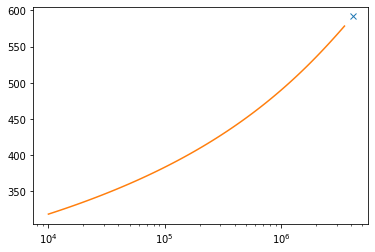

In [47]:
fig, ax =plt.subplots()
Pcrit = CP.PropsSI("Pcrit", "Toluene")
Tcrit = CP.PropsSI("Tcrit", "Toluene")

ax.plot(Pcrit, Tcrit, 'x')
ax.plot(table.SatTable.Psat,table.SatTable.T_vec)
ax.set_xscale('log')


array([  10000.00000006,   11217.71534985,   12555.82234176,
         14023.24749106,   15629.32464433,   17383.79733713,
         19296.82044338,   21378.96113219,   23641.19914837,
         26094.92644274,   28751.94617375,   31624.4711117 ,
         34725.12147193,   38066.92221189,   41663.29982519,
         45528.07866773,   49675.47685344,   54120.10175567,
         58876.94515679,   63961.37807829,   69389.14533887,
         75176.35987313,   81339.49685528,   87895.38766477,
         94861.21373435,  102254.50031948,  110093.11022583,
        118395.23753598,  127179.40136919,  136464.43971372,
        146269.50336533,  156614.05000948,  167517.83848026,
        179000.9232302 ,  191083.64904581,  203786.6460392 ,
        217130.82495032,  231137.37278919,  245827.74885226,
        261223.68114134,  277347.1632176 ,  294220.45152115,
        311866.06318676,  330306.77438794,  349565.61923921,
        369665.88929137,  390631.13364974,  412485.15975303,
        435252.03484455,